In [3]:
library(spectralGraphTopology)
library(sparseGraph)
library(xts)
library(quantmod)
library(igraph)

In [4]:
library(readr)  # to read from csv file
SP500 <- read_csv("SP500_sectors.csv")
# too many sectors
unique(SP500$sector)

Parsed with column specification:
cols(
  stock = col_character(),
  sector = col_character()
)



[1] "Health Care"                 "Materials"                  
 [3] "Industrials"                 "Consumer Discretionary"     
 [5] "Information Technology"      "Consumer Staples"           
 [7] "Utilities"                   "Financials"                 
 [9] "Energy"                      "Real Estate"                
[11] "Telecommunications Services"

In [5]:
# let's select three sectors
selected_sectors <- c("Industrials", "Consumer Staples", "Energy", "Information Technology")
stock_namelist <- SP500$stock[SP500$sector %in% selected_sectors]
# see how many stocks per sector
for (sec in selected_sectors) {
  print(sec)
  print(nrow(SP500[SP500$sector == sec, ]))
}

[1] "Industrials"
[1] 74
[1] "Consumer Staples"
[1] 42
[1] "Energy"
[1] 53
[1] "Information Technology"
[1] 76


In [6]:
# download data
prices <- xts()
for (i in 1:length(stock_namelist)) {
  tryCatch({  # since there are some stocks that are not correctly downloaded
    tmp <- Ad(getSymbols(stock_namelist[i],
                         from = "2016-01-01", to = "2020-05-20", 
                         auto.assign = FALSE, 
                         verbose = FALSE))},
    error = function(e) { tmp <<- NULL }
  )
  if (!is.null(tmp)) {
    colnames(tmp) <- stock_namelist[i]
    prices <- cbind(prices, tmp)
  }
}
anyNA(prices)

‘getSymbols’ currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
‘loadSymbols’ to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.


Warning message:
“APC download failed; trying again.”
Warning message:
“ARG download failed; trying again.”
Warning message:
“BF/B download failed; trying again.”
Warning message:
“BHI contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message:
“BMC contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), 

[1] TRUE

In [7]:
prices <- na.approx(prices, na.rm = FALSE)

In [8]:
column_with_NA <- apply(prices, 2, anyNA)
prices <- prices[, !column_with_NA]
anyNA(prices)

[1] FALSE

In [9]:
larger_than <- function(x, thresh=500) {
    return(any(x > thresh))
}
column_with_unreasonable_price <- apply(prices, 2, larger_than)
column_with_unreasonable_price['CSC'] <- TRUE
prices <- prices[, !column_with_unreasonable_price]

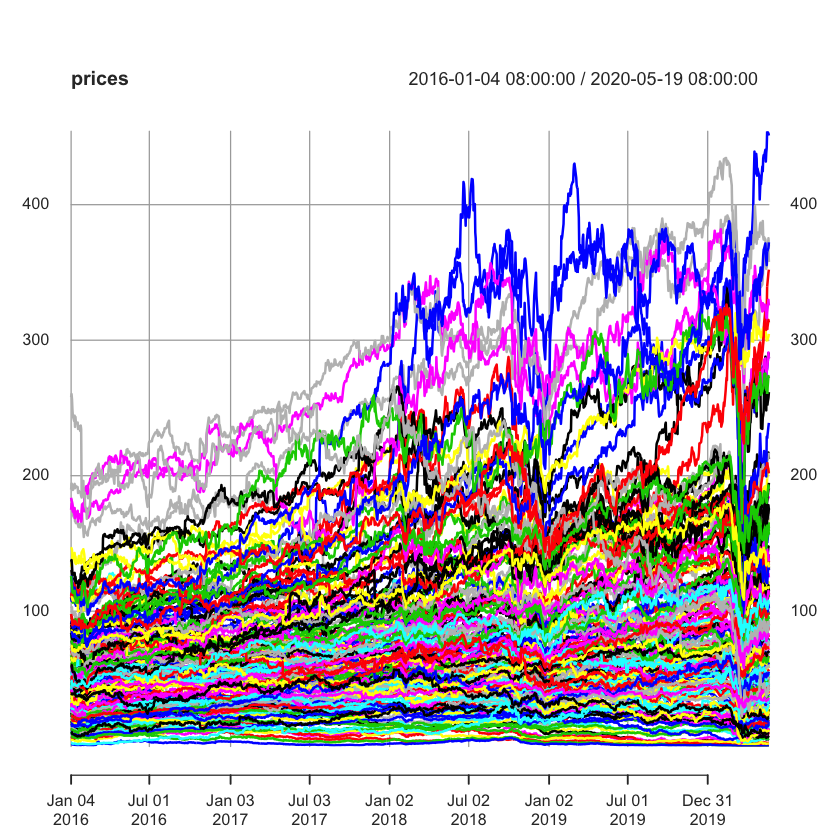

In [10]:
plot(prices)

In [11]:
stock_sectors <- SP500$sector[SP500$stock %in% colnames(prices)]
stock_sectors_index <- as.numeric(as.factor(stock_sectors))
names(stock_sectors_index) <- colnames(prices)
num_sectors <- max(stock_sectors_index)

# compute returns
X_many_stocks <- diff(log(prices), na.pad = FALSE)
N <- ncol(X_many_stocks)  # number of stocks
T <- nrow(X_many_stocks)  # number of days

In [12]:
dim(X_many_stocks)

[1] 1101  181

In [13]:
S <- cor(X_many_stocks)

In [14]:
dim(S)

[1] 181 181

In [15]:
graph_scad <- learn_laplacian_pgd_connected(S = S, alpha = 2.5e-1, sparsity_type = "scad", gamma = 2.01,
                                            maxiter = 10000, verbose = FALSE)

In [16]:
graph_mcp <- learn_laplacian_pgd_connected(S = S, alpha = 2.5e-1, sparsity_type = "mcp", gamma = 1.01,
                                           maxiter = 10000, verbose = FALSE)

In [17]:
graph_scad$elapsed_time[length(graph_scad$elapsed_time)]

elapsed 
160.795

In [18]:
graph_mcp$elapsed_time[length(graph_mcp$elapsed_time)]

elapsed 
 82.442

In [19]:
graph_admm <- learn_laplacian_gle_admm(S = S, alpha = 0, maxiter = 10000,
                                       record_objective = TRUE, verbose = FALSE)

In [20]:
mytriangle <- function(coords, v=NULL, params) {
  vertex.color <- params("vertex", "color")
  if (length(vertex.color) != 1 && !is.null(v)) {
    vertex.color <- vertex.color[v]
  }
  vertex.size <- 1/150 * params("vertex", "size")
  if (length(vertex.size) != 1 && !is.null(v)) {
    vertex.size <- vertex.size[v]
  }

  symbols(x=coords[,1], y=coords[,2], bg=vertex.color,
          stars=cbind(vertex.size, vertex.size, vertex.size),
          add=TRUE, inches=FALSE)
}
# clips as a circle
add_shape("triangle", clip=shapes("circle")$clip,
                 plot=mytriangle)

In [21]:
Adjacency <- graph_scad$adjacency

In [22]:
colors <- c("#eb2f06", "#4a69bd", "#78e08f", "#7d5fff")

In [23]:
net_scad <- graph_from_adjacency_matrix(Adjacency, mode = "undirected", weighted = TRUE)
la_true <- layout_nicely(net_scad)
V(net_scad)$color <- colors[stock_sectors_index]
V(net_scad)$type <- stock_sectors_index
V(net_scad)$cluster <- stock_sectors_index

In [24]:
E(net_scad)$color <- apply(as.data.frame(get.edgelist(net_scad)), 1,
                     function(x) ifelse(V(net_scad)$cluster[x[1]] == V(net_scad)$cluster[x[2]],
                                        colors[V(net_scad)$cluster[x[1]]], 'grey'))

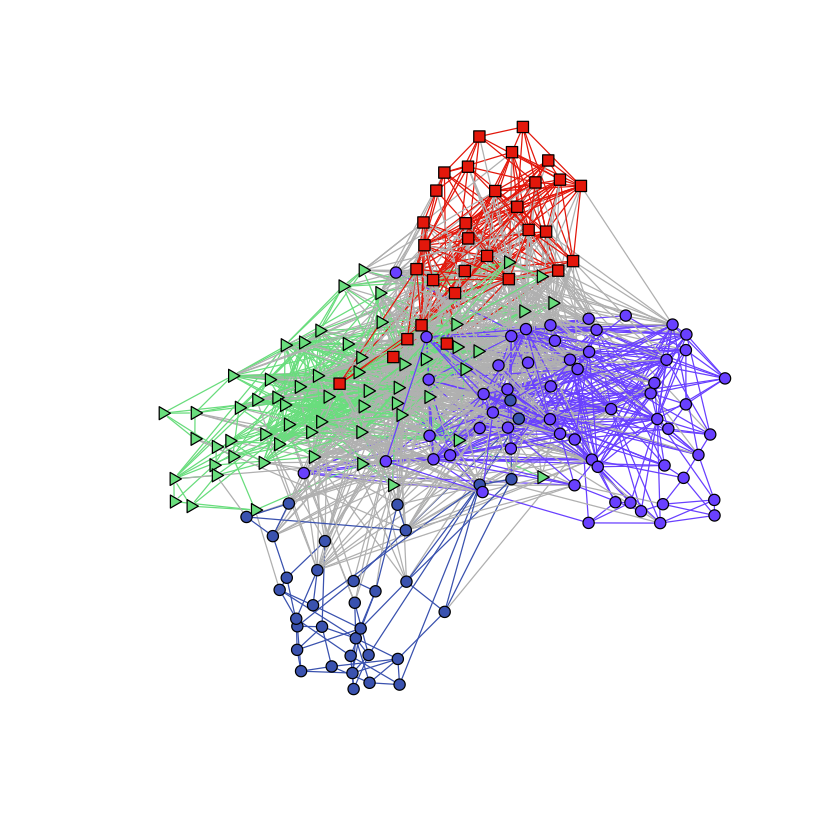

In [25]:
plot(net_scad, vertex.size = 4, vertex.label = NA, vertex.size = 4, vertex.label.cex = .5, layout = la_true,
     vertex.label.family = "Helvetica", vertex.label.color = "black", vertex.label.dist = 1,
     vertex.shape = c("square", "circle", "triangle", "circle")[V(net_scad)$type])

In [26]:
Adjacency <- graph_mcp$adjacency
net_mcp <- graph_from_adjacency_matrix(Adjacency, mode = "undirected", weighted = TRUE)
V(net_mcp)$color <- colors[stock_sectors_index]
V(net_mcp)$type <- stock_sectors_index
V(net_mcp)$cluster <- stock_sectors_index
E(net_mcp)$color <- apply(as.data.frame(get.edgelist(net_mcp)), 1,
                     function(x) ifelse(V(net_mcp)$cluster[x[1]] == V(net_mcp)$cluster[x[2]],
                                        colors[V(net_mcp)$cluster[x[1]]], 'grey'))

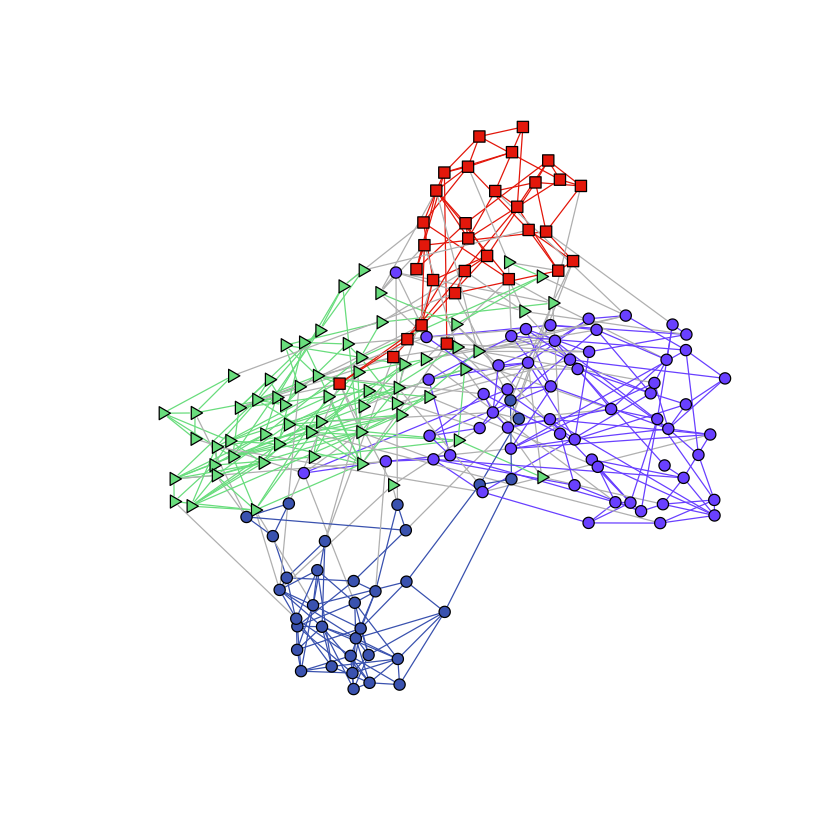

In [27]:
plot(net_mcp, vertex.size = 4, vertex.label = NA, vertex.size = 4, vertex.label.cex = .5, layout = la_true,
     vertex.label.family = "Helvetica", vertex.label.color = "black", vertex.label.dist = 1,
     vertex.shape = c("square", "circle", "triangle", "circle")[V(net_mcp)$type])

In [28]:
Adj <- graph_admm$Adjacency
net <- graph_from_adjacency_matrix(Adj, mode = "undirected", weighted = TRUE)
V(net)$color <- colors[stock_sectors_index]
V(net)$type <- stock_sectors_index
V(net)$cluster <- stock_sectors_index
E(net)$color <- apply(as.data.frame(get.edgelist(net)), 1,
                     function(x) ifelse(V(net)$cluster[x[1]] == V(net)$cluster[x[2]],
                                        colors[V(net)$cluster[x[1]]], 'grey'))

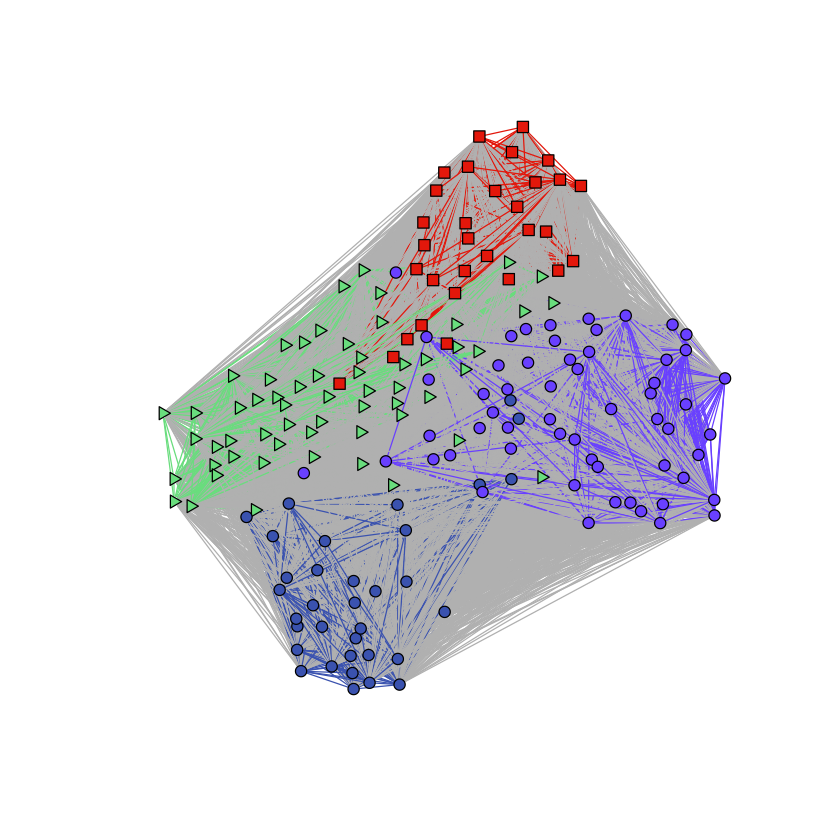

In [29]:
plot(net, vertex.size = 4, vertex.label = NA, vertex.size = 4, vertex.label.cex = .5, layout = la_true,
     vertex.label.family = "Helvetica", vertex.label.color = "black", vertex.label.dist = 1,
     vertex.shape = c("square", "circle", "triangle", "circle")[V(net)$type])